In [ ]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
def load_data_label(feature_path, label_file_path, num_instance = 2000):
    y = pd.read_csv(label_file_path, header=0).drop('song_id',axis=1)
    # Load the data from each file and concatenate into a single feature matrix
    feature_matrix = None
    label_matrix = y[:num_instance]

    for i in range(1, num_instance + 1):
        file_path = os.path.join(feature_path, str(i) + ".mp3.npy")
        # print("Processed file " + file_path)
        data = np.load(file_path)
        data = [np.expand_dims(data, axis=-1)]
        if feature_matrix is None:
            feature_matrix = data
        else:
            feature_matrix = np.concatenate((feature_matrix, data), axis=0)
    return feature_matrix, label_matrix


In [ ]:
def model_middle_feature_construction():
    model = keras.Sequential([
    # 1st Layer
    layers.Conv2D(64, kernel_size=(5, 5), strides = 2 ,activation='relu', padding="valid",input_shape=feature_matrix.shape[1:]),
    layers.BatchNormalization(),
    # 2nd Layer
    layers.Conv2D(64, kernel_size=(3, 3), strides = 1 ,activation='relu', padding="same"),
    layers.BatchNormalization(),
    # 3rd Layer
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.3),
    # 4th Layer
    layers.Conv2D(128, kernel_size=(3, 3), strides = 1, activation='relu', padding="same"),
    layers.BatchNormalization(),
    # 5th Layer
    layers.Conv2D(128, kernel_size=(3, 3), strides = 1, activation='relu', padding="same"),
    layers.BatchNormalization(),
    # 6th Layer
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.3),
    # 7th
    layers.Conv2D(256, kernel_size=(3, 3), strides = 1, activation='relu', padding="same"),
    layers.BatchNormalization(),
    # # 8th
    layers.Conv2D(256, kernel_size=(3, 3), strides = 1, activation='relu', padding="same"),
    layers.BatchNormalization(),
    # # 9th
    layers.Conv2D(384, kernel_size=(3, 3), strides = 1, activation='relu', padding="same"),
    layers.BatchNormalization(),
    # # 10th 
    layers.Conv2D(512, kernel_size=(3, 3), strides = 1, activation='relu', padding="same"),
    layers.BatchNormalization(),
    # # 11th
    layers.Conv2D(256, kernel_size=(3, 3), strides = 1, activation='relu', padding="same"),
    layers.BatchNormalization(),
    # # 12th
    layers.AveragePooling2D(),
    layers.Flatten(),
    layers.Dense(256),
    layers.Dense(7),
])
    return model

In [ ]:
## File parameter
FOLDER_PATH = '/content/drive/MyDrive/music-retrival'
SPECTROGRAM_313x149_SAVE_DIR = FOLDER_PATH+ "/spectograms_313x149_Mel_func"
ANNOTATION_FILE_PATH = FOLDER_PATH + "/annotations.csv"

MODEL_PATH = FOLDER_PATH + '/model' # Change this with your Folder model
## DATA PARAMETER
NUM_INSTANCE = 200 # Change this 5000 
TEST_SIZE = 0.2

## Model Parameter
BATCH_SIZE = 8 
EPOCHS = 50 # Change this 50
MODEL_SAVE = False

In [ ]:
 # load feature, label
feature_matrix, label_matrix = load_data_label(SPECTROGRAM_313x149_SAVE_DIR, ANNOTATION_FILE_PATH, NUM_INSTANCE)

# split train, test
train_features, test_features, train_labels, test_labels = train_test_split(feature_matrix, label_matrix, test_size=TEST_SIZE, random_state=42)

In [ ]:
model = model_middle_feature_construction()

opt = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss='MSE', metrics=[tf.keras.metrics.RootMeanSquaredError(), 'mae', 'mape', 'accuracy'])

In [ ]:
history = model.fit(train_features, train_labels, batch_size=BATCH_SIZE, epochs=5, validation_data=(test_features, test_labels))

Epoch 1/5
20/20 [==============================] - 107s 5s/step - loss: 108.0250 - root_mean_squared_error: 10.3935 - mae: 7.9978 - mape: 159.3330 - accuracy: 0.1937 - val_loss: 1029.4956 - val_root_mean_squared_error: 32.0858 - val_mae: 23.8072 - val_mape: 425.3114 - val_accuracy: 0.0000e+00
Epoch 2/5
20/20 [==============================] - 109s 5s/step - loss: 139.4306 - root_mean_squared_error: 11.8081 - mae: 9.2709 - mape: 185.7893 - accuracy: 0.1937 - val_loss: 57.3471 - val_root_mean_squared_error: 7.5728 - val_mae: 6.0276 - val_mape: 110.9583 - val_accuracy: 0.1500
Epoch 3/5
20/20 [==============================] - 105s 5s/step - loss: 83.4882 - root_mean_squared_error: 9.1372 - mae: 7.0869 - mape: 142.0812 - accuracy: 0.1875 - val_loss: 126.4164 - val_root_mean_squared_error: 11.2435 - val_mae: 9.0587 - val_mape: 178.0839 - val_accuracy: 0.1000
Epoch 4/5
20/20 [==============================] - 109s 5s/step - loss: 59.9023 - root_mean_squared_error: 7.7397 - mae: 6.2091 - mape

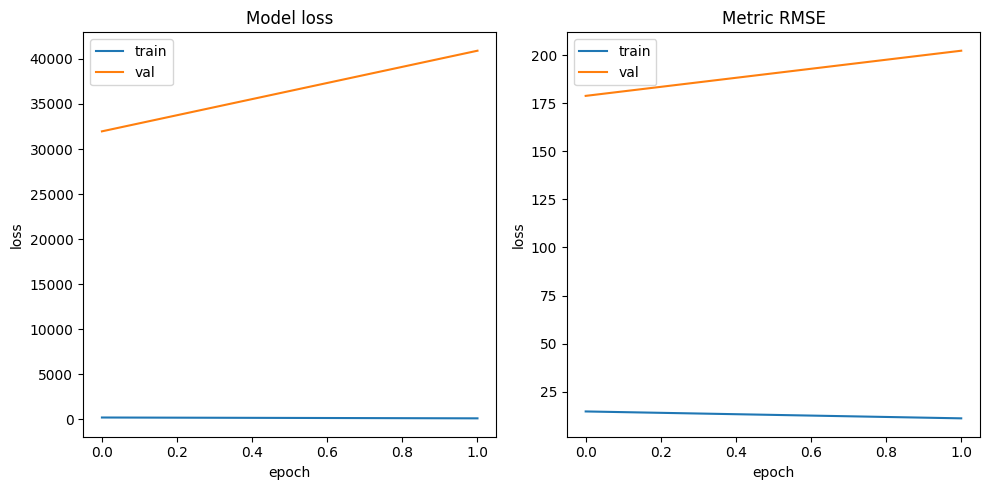

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('Model loss')
# ax1.ylabel('loss')
# ax1.xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')
ax1.set(xlabel='epoch', ylabel='loss')

ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.set_title('Metric RMSE')
# ax2.ylabel('loss')
# ax2.xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')
ax2.set(xlabel='epoch', ylabel='loss')

fig.tight_layout()

In [ ]:
if MODEL_SAVE == True:
  model.save(MODEL_PATH+"cnn_M2E")

In [ ]:
y_pred = model.predict(test_features)
y_test = test_labels

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
mse = mean_squared_error(y_test, y_pred)

# Compute the R-squared value
r2 = r2_score(y_test, y_pred)

# Compute the mean absolute error
mae = mean_absolute_error(y_test, y_pred)

# Print the evaluation metrics
print('Mean squared error: {:.2f}'.format(mse))
print('R-squared value: {:.2f}'.format(r2))
print('Mean absolute error: {:.2f}'.format(mae))

y_pred = pd.DataFrame(y_pred)
y_pred.columns = y_test.columns.values

cor_df = dict()
print('-------------------------------')
for i in y_test.columns.values:
  corr_coef = round(np.corrcoef(y_test[i], y_pred[i])[0, 1], 2)
  if 'Emotion' not in cor_df:
    cor_df['Emotion'] = [i]
    cor_df['Correlation'] = [corr_coef]
  else:
    cor_df['Emotion'] += [i]
    cor_df['Correlation'] += [corr_coef]
cor_df = pd.DataFrame(cor_df)
cor_df